# Imports

In [37]:
import numpy as np
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import data_preprocessing as dp

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, MaxPool2D, Conv2D, Conv2DTranspose, \
   Concatenate, Dropout, LeakyReLU, Dense, Activation, Resizing, MaxPooling2D, UpSampling2D

# Constants

In [2]:
# Panama
shape_path = "data/Panama/panama_rect.shx"

list_unmerged_rasters = ["data/Panama/S2_panama_T17PPK_20211210.tif", "data/Panama/S2_panama_T17PPL_20221210.tif"]
s2_merged_path_no_process = "data/Panama/S2_merged_20211210.tif"
s2_merged_path_process = 'data/Panama/S2_merged_20211210_reproj.tif'

s1_path_no_process = "data/Panama/S1_inter_20220128_20220209.geo.unw.tif"
s1_path_process = 'data/Panama/S1_inter_20220128_20220209_reproj.geo.unw.tif'

capella_path_no_process = "data/Panama/CAPELLA_C09_SM_GEO_HH_20240806035526_20240806035544.tif"

iceye_path_no_process = "data/Panama/ICEYE_GRD_SC_244270_20220207T192226.tif_Cal_Spk_TC.tif"
iceye_path_process = 'data/Panama/ICEYE_GRD_SC_244270_20220207T192226.tif_Cal_Spk_TC_reproj.tif'

FIRST_LOCATION_RUN = False
WANTED_RES = 0.00018 # approx 20 meters

# Data preprocessing

## Shapefile

In [3]:
aoi = dp.get_aoi_geometry(shape_path, FIRST_LOCATION_RUN)
aoi = aoi.set_crs("EPSG:4326", allow_override=True)

## Optical

### Sentinel 2

Sentinel 2 optical data:
- Compute desired VIs and BPVs

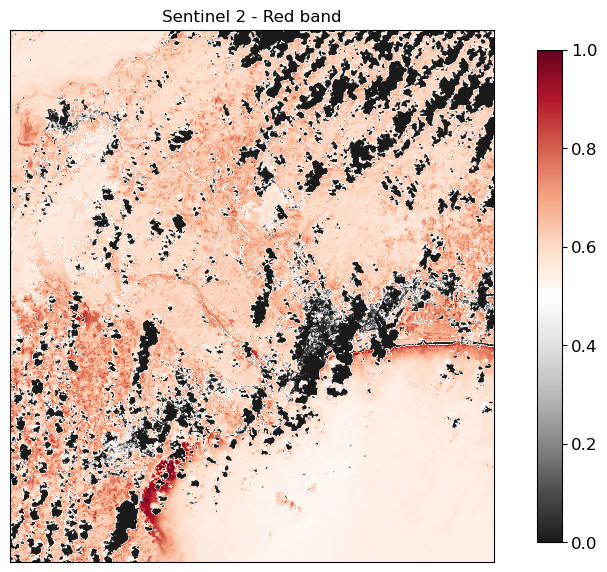

In [4]:
if FIRST_LOCATION_RUN:
    dp.merge_rasters(list_unmerged_rasters, s2_merged_path_no_process)
    dp.reproject_and_clip_raster(s2_merged_path_no_process, aoi.geometry, s2_merged_path_process)
    
else:
    s2_data, s2_profile = dp.open_tif_file(s2_merged_path_process)
    
    s2_data_processed = np.zeros(s2_data.shape)
    for band in range(s2_data.shape[0]):
        vmin, vmax = np.percentile(s2_data[band], [0, 99]) #- cut top 1 percent for all bands
        temp = np.where(s2_data[band] <= vmax, s2_data[band], 0)
        s2_data_processed[band] = dp.min_max_normalize(temp)


    fig = plt.figure(figsize=(8, 8))
    im = plt.imshow(s2_data_processed[3], cmap='RdGy_r') #gist_heat
    plt.xticks([]); plt. yticks([])
    cbar = plt.colorbar(im, shrink=0.8, pad=0.07)
    cbar.ax.tick_params(labelsize=12)
    plt.title('Sentinel 2 - Red band')
    plt.show()

## SAR

### Sentinel 1

Interferogram
- double chek the width/height, it seems like its one off

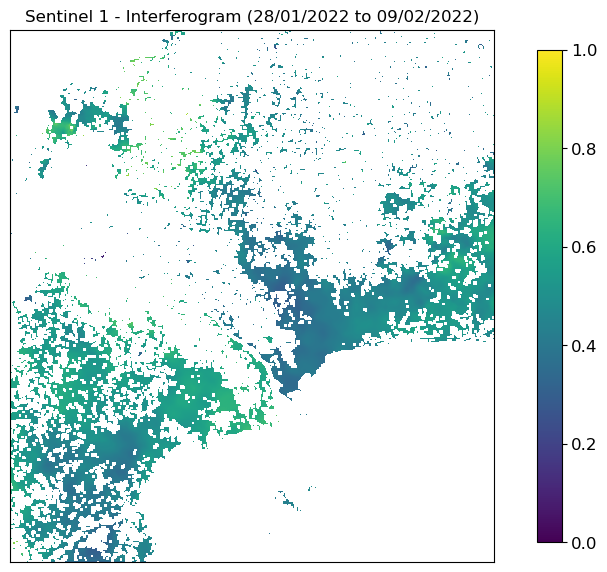

In [5]:
if FIRST_LOCATION_RUN:
    dp.reproject_and_clip_raster(s1_path_no_process, aoi.geometry, s1_path_process)
else:
    s1_interferogram, s1_interferogram_profile = dp.open_tif_file(s1_path_process)
    s1_interferogram = dp.min_max_normalize(s1_interferogram)
    s1_interferogram = np.pad(s1_interferogram, ((0, 0), (0, 1), (0, 0)), mode='constant')[:, :, :3963]

    fig = plt.figure(figsize=(8, 8))
    im = plt.imshow(s1_interferogram[0], cmap='viridis')
    plt.xticks([]); plt. yticks([])
    cbar = plt.colorbar(im, shrink=0.8, pad=0.07)
    cbar.ax.tick_params(labelsize=12)
    plt.title('Sentinel 1 - Interferogram (28/01/2022 to 09/02/2022)')
    plt.show()

### Iceye

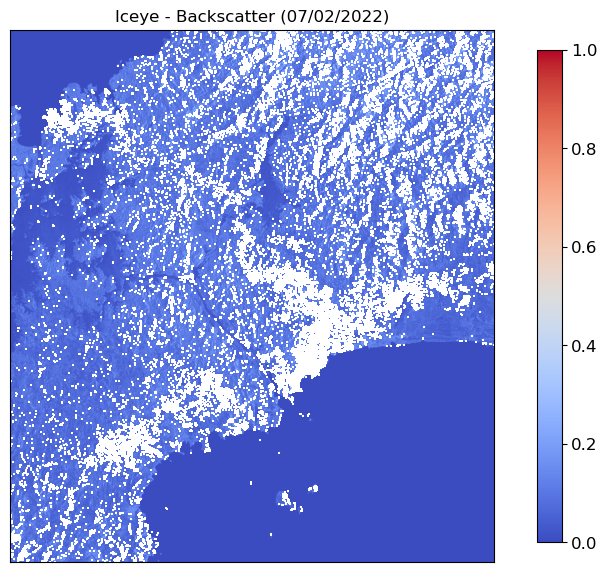

In [6]:
if FIRST_LOCATION_RUN:
    dp.reproject_and_clip_raster(iceye_path_no_process, aoi.geometry, iceye_path_process)
else:
    iceye_image, iceye_profile = dp.open_tif_file(iceye_path_process)

    vmin, vmax = np.percentile(iceye_image[0], [0, 99.5])
    iceye_no_outliers = np.where(iceye_image[0] <= vmax, iceye_image[0], np.nan)
    iceye_no_outliers = dp.min_max_normalize(iceye_no_outliers)

    fig = plt.figure(figsize=(8, 8))
    im = plt.imshow(iceye_no_outliers, cmap='coolwarm')
    plt.xticks([]); plt. yticks([])
    cbar = plt.colorbar(im, shrink=0.8, pad=0.07)
    cbar.ax.tick_params(labelsize=12)
    plt.title('Iceye - Backscatter (07/02/2022)')
    plt.show()

## Data stacking

In [7]:
combined = np.concatenate((s2_data, s1_interferogram, iceye_image), axis=0)

## Reference Data

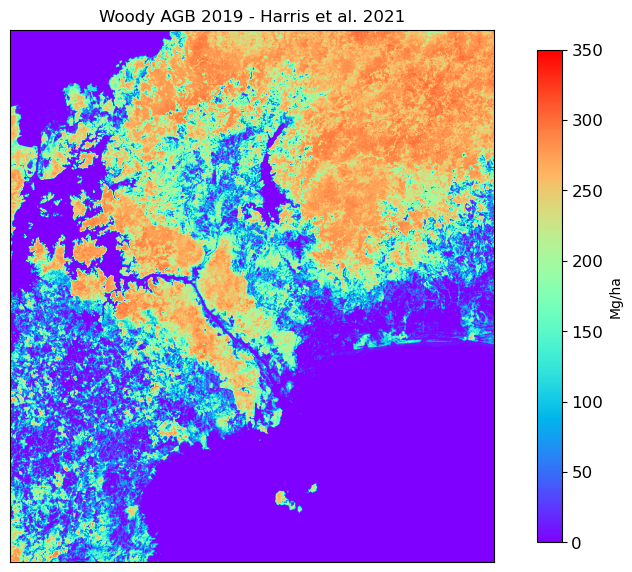

In [8]:
if FIRST_LOCATION_RUN:
    dp.reproject_and_clip_raster('data/Panama/10N_080W.tif', aoi.geometry, 'data/Panama/ref_data_abg_woody.tif')
else:
    ref_data, ref_data_profile = dp.open_tif_file('data/Panama/ref_data_abg_woody.tif')

    ref_no_outliers = np.expand_dims(ref_data[0], axis=0)[:, :, :3963]

    fig = plt.figure(figsize=(8, 8))
    im = plt.imshow(ref_no_outliers[0], cmap='rainbow', vmax=350)
    plt.xticks([]); plt. yticks([])
    cbar = plt.colorbar(im, shrink=0.8, pad=0.07, label='Mg/ha')
    cbar.ax.tick_params(labelsize=12)
    plt.title('Woody AGB 2019 - Harris et al. 2021')
    plt.show()


# Train model

In [9]:
n_bands, height, width = combined.shape
n_pixels = height * width

# Reshape to make the bands last
X_2d = np.transpose(combined, (1, 2, 0)).reshape(n_pixels, n_bands)       # (w*h, 14)
y_1d = ref_no_outliers.reshape(n_pixels)             # (w*h, )

# Impute missing values in X (mean strategy)
imputer = SimpleImputer(strategy='mean')
X_2d = imputer.fit_transform(X_2d)

# Split into test and train 
X_train, X_test, y_train, y_test = train_test_split(
    X_2d, y_1d, test_size=0.3, random_state=42
)

## Multiple linear regression

In [10]:
# Fit linear regression model
model = LinearRegression()
model.fit(X_2d, y_1d)

LinearRegression()

In [11]:
# Predict
y_pred = model.predict(X_2d)

# Compute metrics
mse = mean_squared_error(y_1d, y_pred)
r2 = r2_score(y_1d, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Reshape prediction to original 2D format for visualization or further use
y_pred_image = y_pred.reshape(height, width)

Mean Squared Error: 6827.462890625
R² Score: 0.5001369714736938


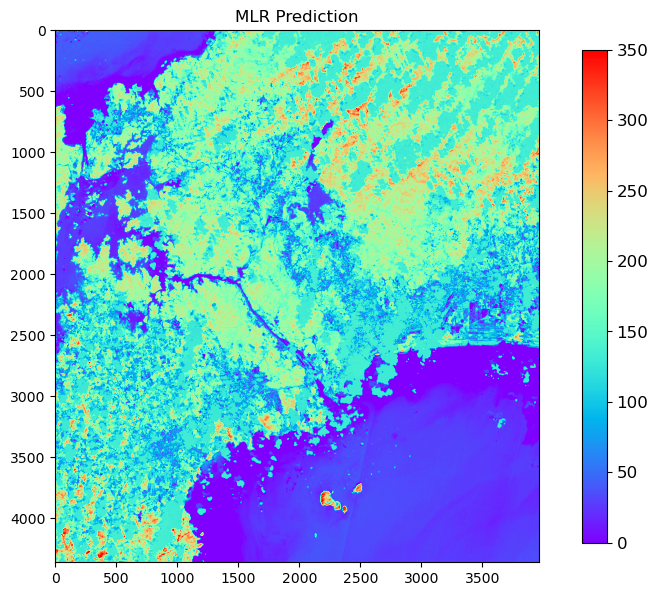

In [12]:
fig = plt.figure(figsize=(8, 8))
im = plt.imshow(y_pred_image, cmap='rainbow', vmin=0,  vmax=350)
cbar = plt.colorbar(im, shrink=0.8, pad=0.07)
cbar.ax.tick_params(labelsize=12)
plt.title('MLR Prediction')
plt.show()

## Random forest

In [13]:
# Build random forest model
rf = RandomForestRegressor(
    n_estimators=50,       # fewer trees → faster
    max_depth=15,          # cap tree height → fewer splits
    max_samples=0.25,      # each tree sees only 25% of pixels
    max_features=5,        # at each split, consider 5 of the 8 PCA features
    n_jobs=-1,             # use all CPU cores
    random_state=42,
    verbose=1
)

# Fit on training
rf.fit(X_train, y_train)

# Evaluate on test set
test_score = rf.score(X_test, y_test)
print(f"Test set accuracy: {test_score:.4f}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 17.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   19.7s


Test set accuracy: 0.6994


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   23.0s finished


In [14]:
# Predict the values
predictions_1d = rf.predict(X_2d)

# Reshape back into the raster
predictions_2d = predictions_1d.reshape(height, width)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  2.1min finished


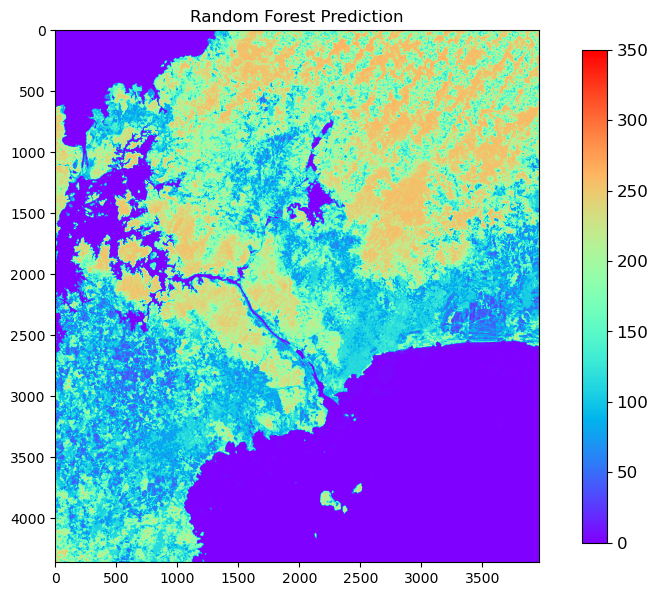

In [15]:
# Vizualize results
# np.save("data/Panama/rf_predictions.npy", predictions_2d)

fig = plt.figure(figsize=(8, 8))
im = plt.imshow(predictions_2d, cmap='rainbow', vmin=0,  vmax=350)
cbar = plt.colorbar(im, shrink=0.8, pad=0.07)
cbar.ax.tick_params(labelsize=12)
plt.title('Random Forest Prediction')
plt.show()

## Gradient boosted trees

In [16]:
# Train XGBoost (handles NaNs internally)
model = xgb.XGBRegressor(tree_method='hist')  # 'hist' is faster for large data
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [17]:
# Predict and evaluate
y_pred = model.predict(X_2d)
print("MSE:", mean_squared_error(y_1d, y_pred))
print("R²:", r2_score(y_1d, y_pred))

MSE: 4071.9143
R²: 0.7018805742263794


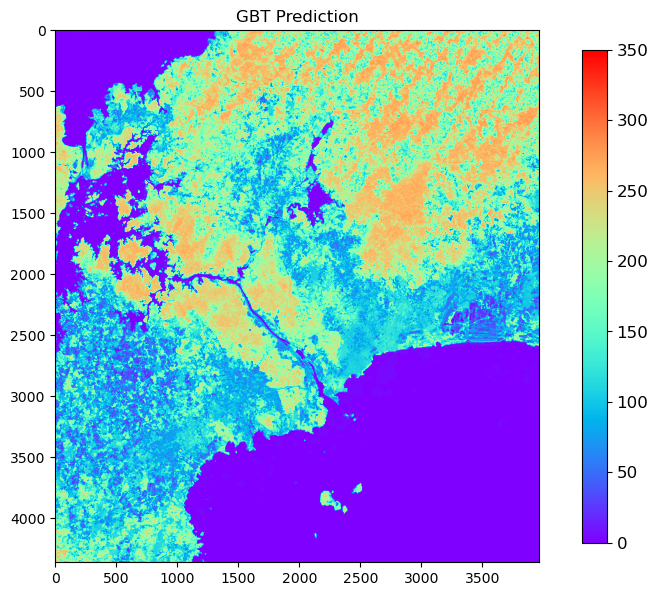

In [18]:
# Reshape back into the raster
predictions_2d = y_pred.reshape(height, width)
fig = plt.figure(figsize=(8, 8))
im = plt.imshow(predictions_2d, cmap='rainbow', vmin=0,  vmax=350)
cbar = plt.colorbar(im, shrink=0.8, pad=0.07)
cbar.ax.tick_params(labelsize=12)
plt.title('GBT Prediction')
plt.show()

## Convolutional neural networks

In [ ]:
# Add batch dimension
X_tf = np.transpose(X_train, (1, 2, 0))      # (4000, 4000, 14)
y_tf = np.transpose(ref_data, (1, 2, 0))      # (4000, 4000, 1)

X_tf_b = np.expand_dims(X_tf, axis=0)    # (1, 4000, 4000, 14)
y_tf_b = np.expand_dims(y_tf, axis=0)      # (1, 4000, 4000, 1)

In [44]:
def cnn_model_maker(x, filters_n_kernels):
    '''Builds a model with either cyclone or river architecture for input of the 
    shape of the input x, and returns the model.'''

    input_shape = (x.shape[0], x.shape[1], x.shape[2])  # Expecting (H, W, C)
    inputs = Input(shape=input_shape)

    # First Conv + Pool
    c1 = Conv2D(filters=filters_n_kernels[0], kernel_size=filters_n_kernels[1],
                activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D(pool_size=filters_n_kernels[2], strides=2, padding='same')(c1)

    # Second Conv + Pool
    c2 = Conv2D(filters=filters_n_kernels[3], kernel_size=filters_n_kernels[4],
                activation='relu', padding='same')(p1)
    p2 = MaxPooling2D(pool_size=filters_n_kernels[5], strides=2, padding='same')(c2)

    # Upsample back to input size
    u1 = UpSampling2D(size=2)(p2)
    u2 = UpSampling2D(size=2)(u1)

    # Final convolution to single output channel
    output = Conv2D(filters=1, kernel_size=1, activation='sigmoid', padding='same')(u2)

    model = Model(inputs=inputs, outputs=output)

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_logarithmic_error', 'mean_absolute_error'])

    return model


In [45]:
cnn_model = cnn_model_maker(X_tf, [8, (5,5), (2,2), 16, (5,5), (2,2), 50])
cnn_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 4360, 3963, 14) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 4360, 3963, 8)  │         2,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 2180, 1982, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 2180, 1982, 16) │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 1090, 991, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 2180, 1982, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 4360, 3964, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 4360, 3964, 1)  │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,041 (23.60 KB)

 Trainable params: 6,041 (23.60 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn_model.fit(X_tf_b, y_tf_b, epochs=10, batch_size=len(X_tf)//10)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 356s 356s/step - loss: nan - mean_absolute_error: nan - mean_squared_logarithmic_error: nan
Epoch 2/10


In [ ]:
y_pred = cnn_model.predict(X_test)